In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pqcd
import os

from pqcd.utils import (
    to_GeV_per_cubic_femtometre, 
    to_nucleons_per_cubic_femtometre, 
    nsat
)

### Modify the stitch index only

This controls how steep the convergence $c_s^2 \rightarrow 1/3$ is.

stitch_index=-5.0: 12 good EOSs, 1.2% efficiency
stitch_index=-4.0: 17 good EOSs, 1.7% efficiency
stitch_index=-3.0: 16 good EOSs, 1.6% efficiency
stitch_index=-2.0: 12 good EOSs, 1.2% efficiency


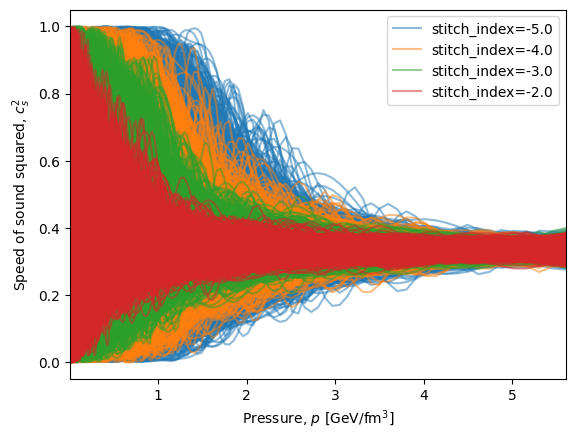

In [2]:
# Campaign numbers to compare
sets = [16, 2, 0, 1]

# Save the variety and number of each pQCD-consistent EOS
good_eos_dict = {s: [] for s in sets}
pqcd_region_dict = pqcd.get_pqcd_region()

# Campaign descriptions
set_keys = {
    16: 'stitch_index=-5.0',
    2: 'stitch_index=-4.0',
    0: 'stitch_index=-3.0',
    1: 'stitch_index=-2.0',
}

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):
            
            if s == 16:
                eos = pd.read_csv(
                    f'../data/eos-draws-modified/tests/{s:02}/{variety}agn/'
                    f'DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
                )
            else:
                eos = pd.read_csv(
                    f'../data/eos-draws-modified/tests/{s:02}/{variety}agn/'
                    f'eos-draw-{n:06}.csv'
                )

            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_eos_dict[s].append((variety, n))

            pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.legend()

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

for key, label in set_keys.items():
    print(
        f'{label}: {len(good_eos_dict[key])} good EOSs, '
        f'{100*len(good_eos_dict[key])/N}% efficiency'
    )

### Modify stitch sigma only (with the stitch index fixed to $-3$)

This controls the spread of $c_s^2$ around $1/3$.

stitch_sigma=0.5: 29 good EOSs, 2.9% efficiency
stitch_sigma=0.1: 16 good EOSs, 1.6% efficiency
stitch_sigma=0.02: 6 good EOSs, 0.6% efficiency


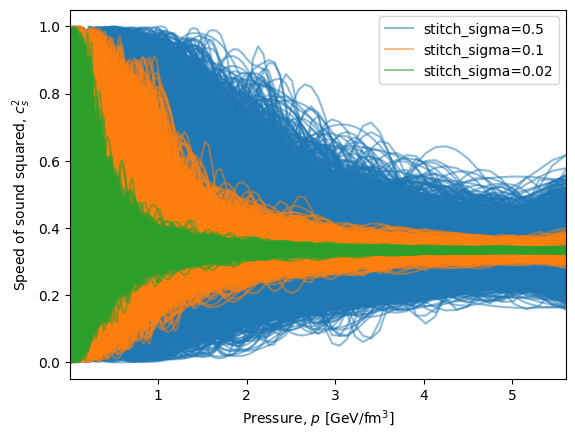

In [3]:
# Campaign numbers to compare
sets = [3, 0, 4]

# Save the variety and number of each pQCD-consistent EOS
good_eos_dict = {s: [] for s in sets}
pqcd_region_dict = pqcd.get_pqcd_region()

# Campaign descriptions
set_keys = {
    3: 'stitch_sigma=0.5',
    0: 'stitch_sigma=0.1',
    4: 'stitch_sigma=0.02',
}

# Number of EOS draws
N = 1000

min_pressure = to_GeV_per_cubic_femtometre(1e10)
max_pressure = to_GeV_per_cubic_femtometre(1e16)

fig, ax = plt.subplots()

for i, s in enumerate(sets):
    for variety in ['had', 'hyp', 'qrk']:
        for n in range(N):

            eos = pd.read_csv(
                f'../data/eos-draws-modified/tests/{s:02}/{variety}agn/eos-draw-{n:06}.csv'
            )

            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_eos_dict[s].append((variety, n))

            pressure = to_GeV_per_cubic_femtometre(eos.pressurec2)
            energy_density = to_GeV_per_cubic_femtometre(eos.energy_densityc2)
            number_density = to_nucleons_per_cubic_femtometre(eos.baryon_density)

            chemical_potential = (energy_density+pressure)/number_density
            speed_of_sound_squared = np.gradient(pressure, energy_density)

            ax.plot(
                pressure,
                speed_of_sound_squared, 
                alpha=0.5, 
                c=f'C{i}',
                label=set_keys[s] if (n==0) and (variety=='had') else None
                )

ax.legend()

ax.set_xlim(min_pressure, max_pressure)

ax.set_xlabel(r'Pressure, $p$ [GeV/fm$^3$]')
ax.set_ylabel(r'Speed of sound squared, $c_s^2$')

for key, label in set_keys.items():
    print(
        f'{label}: {len(good_eos_dict[key])} good EOSs, '
        f'{100*len(good_eos_dict[key])/N}% efficiency'
    )

### Other tests

In [4]:
def test_set(set_number, N, varieties=['had', 'hyp', 'qrk']):

    good_eos_list = []
    pqcd_region_dict = pqcd.get_pqcd_region()

    fig, ax = plt.subplots()

    ax.plot(
        pqcd_region_dict['left_n_boundary']/nsat, 
        pqcd_region_dict['left_p_boundary'], 
        c='k',
        zorder=2
        )

    ax.plot(
        pqcd_region_dict['right_n_boundary']/nsat, 
        pqcd_region_dict['right_p_boundary'], 
        c='k',
        zorder=2
        )

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    for variety in varieties:
        for n in range(N):

            if 'DRAWmod1000-000000' in os.listdir(
                f'../data/eos-draws-modified/tests/{set_number:02}/{variety}agn/'
            ):
                eos = pd.read_csv(
                    f'../data/eos-draws-modified/tests/{set_number:02}/{variety}agn/'
                    f'DRAWmod1000-{int(n/1000):06}/eos-draw-{n:06}.csv'
                )
            else:
                eos = pd.read_csv(
                    f'../data/eos-draws-modified/tests/{set_number:02}/{variety}agn/'
                    f'eos-draw-{n:06}.csv'
                )
            
            if pqcd.consistent_with_pqcd(eos, pqcd_region_dict):
                good_eos_list.append((variety, n))
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C0'
                )
            
            else:
                ax.plot(
                    to_nucleons_per_cubic_femtometre(eos.baryon_density)/nsat,
                    to_GeV_per_cubic_femtometre(eos.pressurec2),
                    c='C3',
                    alpha=0.05,
                    lw=1,
                    zorder=0.5
                )

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    ax.set_xlabel(r'Number density, $n$ [$n_{\rm sat}$]')
    ax.set_ylabel(r'Pressure, $p$ [GeV/fm$^3$]')

    print(
        f'{len(good_eos_list)} out of {N} good EOSs, '
        f'{100*len(good_eos_list)/N}% efficiency'
    )

4 out of 1000 good EOSs, 0.4% efficiency


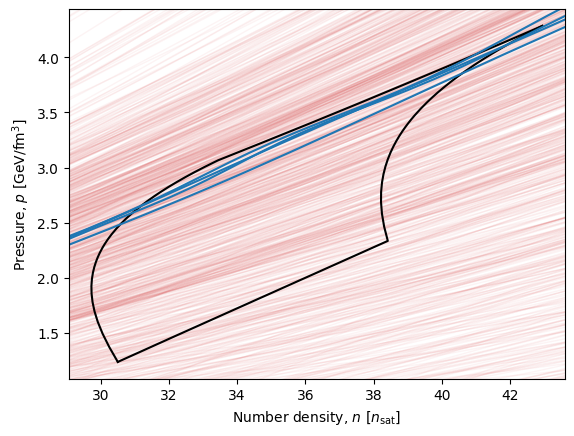

In [5]:
# qrk alf only
test_set(5, N=1000, varieties=['qrk'])

22 out of 2000 good EOSs, 1.1% efficiency


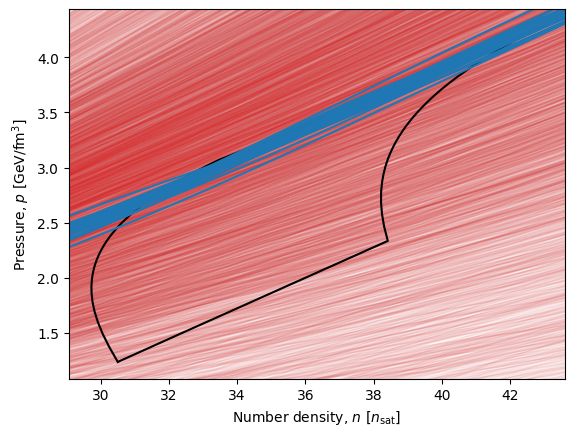

In [6]:
# default mean
test_set(6, N=2000)

22 out of 5000 good EOSs, 0.44% efficiency


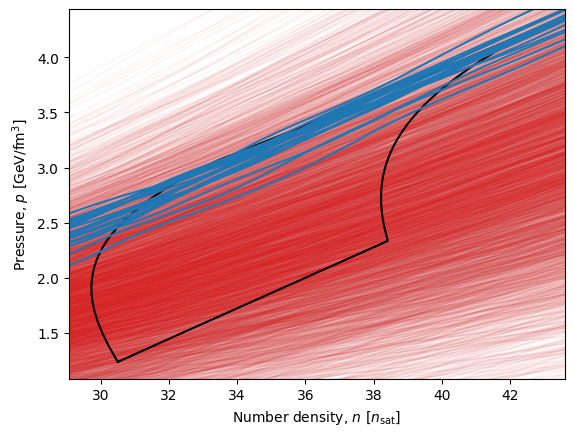

In [7]:
# custom mean; single pQCD-consistent EOS with some smoothing
test_set(8, N=5000, varieties=['qrk'])

15 out of 5000 good EOSs, 0.3% efficiency


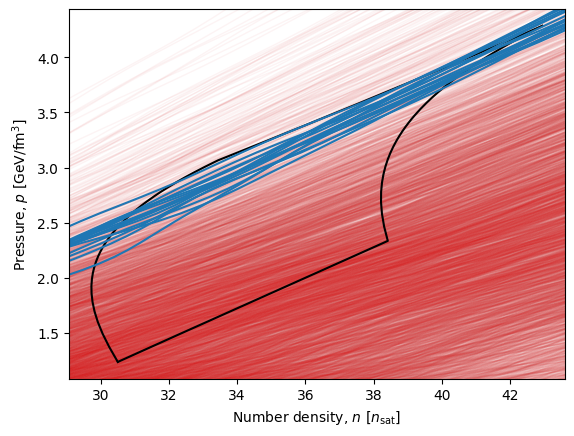

In [8]:
# custom mean
test_set(9, N=5000, varieties=['qrk'])

4 out of 5000 good EOSs, 0.08% efficiency


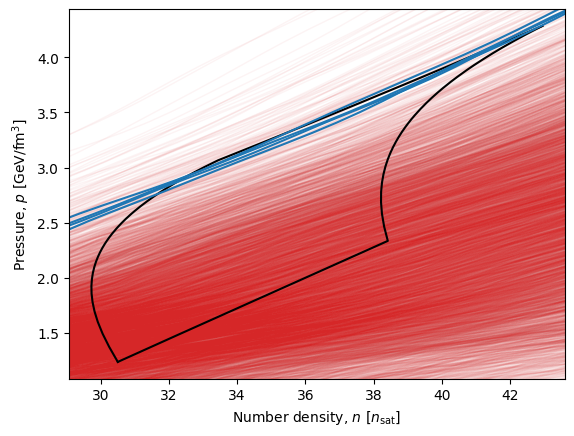

In [9]:
# custom mean
test_set(10, N=5000, varieties=['qrk'])

38 out of 2000 good EOSs, 1.9% efficiency


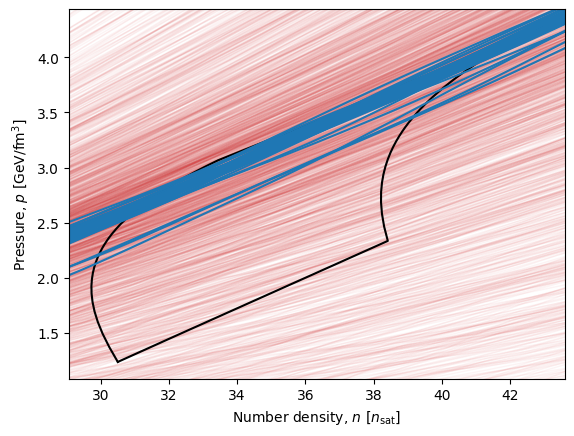

In [10]:
# custom mean
test_set(14, N=2000, varieties=['cus'])

12 out of 2000 good EOSs, 0.6% efficiency


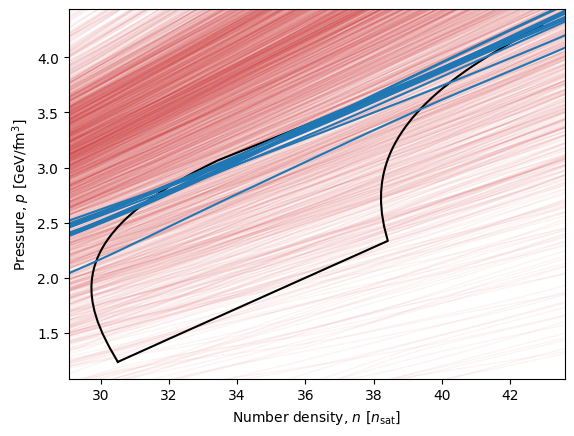

In [11]:
# custom mean
test_set(15, N=2000, varieties=['cus'])